# Simulation of the Finnish population development

This project provides overly simplified simulation of the Finnish population development. This simulation is merely for fun.

## Data sources

This simulation initializes itself with official data from [Statistics Finland](https://www.stat.fi/index_en.html).

Initial population distribution of sexes and ages has been generated using following statistics using year 2020: \
StatFin / Population / Population structure / 11rd -- Population according to age (1-year 0-112) and sex, 1972-2021 \
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__vaerak/statfin_vaerak_pxt_11rd.px/chart/chartViewColumn/

Lifetime simulation uses following statistics using year 2020: \
StatFin / Population / Deaths / 12ap -- Life table by age and sex, 1986-2020
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__kuol/statfin_kuol_pxt_12ap.px/chart/chartViewColumn/

Birth rate simulation uses following statistics using year 2020: \
StatFin / Population / Births / 12dm -- Live births by sex, birth order and age of mother (1-year), 1990-2020 \
https://pxnet2.stat.fi/PXWeb/pxweb/en/StatFin/StatFin__vrm__synt/statfin_synt_pxt_12dm.px/table/tableViewLayout1/

## A results sneak peek

![Animated age by sex over simulations](../images/age_by_sex_distribution_animation.gif?q=2)

## Theory for the simulation

TBD

## Code / Implementation

### Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme()

### Constants

In [2]:
class Cfg:
    # 0 = male, 1 = female
    SEXES = [0, 1] 
    MAX_AGE = 120
    
    DATA_DIR = os.path.join(os.pardir, 'data')
    IMAGE_DIR = os.path.join(os.pardir, 'images')
    
    # If running this notebook can overwrite previous image results
    OVERWRITE_IMAGES = True
    
    # Initial year (starting from). Should not be changed since we uses statistcs from year 2020.
    INITIAL_YEAR = 2020
    # End / Target year of the simulation. Should be greater than 2020.
    TARGET_YEAR = 2080
    
    # Probability that single baby is male. Female probability is 1-MALE_BIRTH_PROBABILITY.
    MALE_BIRTH_PROBABILITY = 0.511

### Population by age and sex

In [3]:
stats_population_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '004_11rd_2020_20220319-004320.csv'), encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_population_dataframe(df):
    df['sex'] = df['Sukupuoli'].apply(lambda x: 1 if x == 'Miehet' else 0)
    df = df.rename(columns={'2020': 'population_count', 'Ikä': 'age'})
    df = df.drop(df.columns.difference(['sex', 'population_count', 'age']), 1)
    return df


stats_population_df = tilastokeskus_transform_population_dataframe(stats_population_df)

stats_population_df.head()

,age,population_count,sex
0,0,23806,1
1,1,23459,1
2,2,25012,1
3,3,26298,1
4,4,27634,1


In [4]:
def plot_population_age_distributions_by_sex(df, year=None, aggregated=True, save_with_filename=None):
    a4_dims = (15, 6)
    fig, ax = plt.subplots(1, 2, figsize=a4_dims)
    for a in ax:
        a.set_ylim(top=45000)
    if not aggregated:
        df = df.groupby(['sex', 'age']).size().reset_index(name='population_count')
    males = df[df['sex'] == 1]
    females = df[df['sex'] == 0]
    mp = sns.histplot(x=males['age'], weights=males['population_count'], binrange=(0, Cfg.MAX_AGE), binwidth=1, ax=ax[0])
    mp.set_title(f"Age distribution of males{' - {}'.format(year) if year else ''}")
    fp = sns.histplot(x=females['age'], weights=females['population_count'],  binrange=(0, Cfg.MAX_AGE), binwidth=1, ax=ax[1])
    fp.set_title(f"Age distribution of females{' - {}'.format(year) if year else ''}")
    
    if save_with_filename:
        filepath = os.path.join(Cfg.IMAGE_DIR, save_with_filename)
        if os.path.exists(filepath) and not Cfg.OVERWRITE_IMAGES:
            raise Exception(f"Image {save_with_filename} already exists")
        plt.savefig(filepath)

    fig.show()

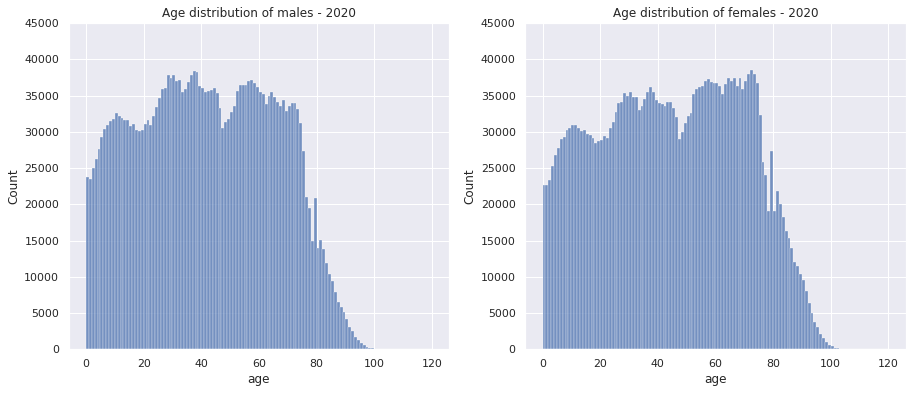

In [5]:
plot_population_age_distributions_by_sex(stats_population_df, year=2020, save_with_filename="age_by_sex_distribution_2020.png")

### Lifetime by age and sex

In [6]:
stats_lifetime_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '002_12ag_2020_20220318-232408.csv'), encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_lifetime_dataframe(df):
    df['sex'] = df['Sukupuoli'].apply(lambda x: 1 if x == 'Miehet' else 0)
    df = df.rename(columns={'2020': 'dead_count', 'Ikä': 'age'})
    df = df.drop(df.columns.difference(['sex', 'dead_count', 'age']), 1)
    return df

stats_lifetime_df = tilastokeskus_transform_lifetime_dataframe(stats_lifetime_df)

stats_lifetime_df.head()

,age,dead_count,sex
0,0,49,1
1,1,5,1
2,2,2,1
3,3,3,1
4,4,5,1


In [7]:
def plot_lifetime_distributions_by_sex(df):
    a4_dims = (15, 6)
    fig, ax = plt.subplots(1, 2, figsize=a4_dims)
    males = df[df['sex'] == 1]
    females = df[df['sex'] == 0]
    mp = sns.histplot(data=males, x=males['age'], weights=males['dead_count'], binwidth=1, ax=ax[0])
    mp.set_title("Lifetime distribution of males")
    fp = sns.histplot(data=females, x=females['age'], weights=females['dead_count'], binwidth=1, ax=ax[1])
    fp.set_title("Lifetime distribution of females")
    fig.show()

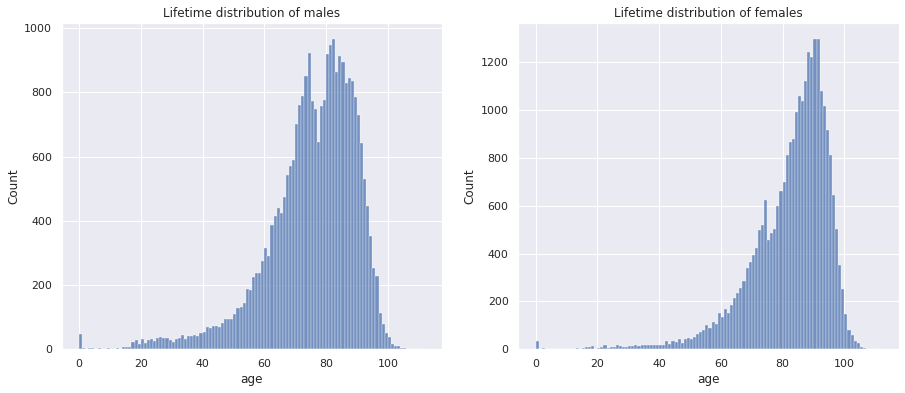

In [8]:
plot_lifetime_distributions_by_sex(stats_lifetime_df)

### Risk of death

In [9]:
stats_death_risk_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '008_12ap_2020_20220321-001345.csv'), 
                                  encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_deathrisk_dataframe(df):
    df['sex'] = df['Sukupuoli'].apply(lambda x: 1 if x == 'Miehet' else 0)
    df = df.rename(columns={'2020': 'death_probability', 'Ikä': 'age'})
    df['death_probability'] = df['death_probability'].apply(pd.to_numeric, errors='coerce')
    df['death_probability'] = df['death_probability'] / 1000
    df = df.drop(df.columns.difference(['sex', 'death_probability', 'age']), 1)
    df = df.dropna()
    return df

stats_death_risk_df = tilastokeskus_transform_deathrisk_dataframe(stats_death_risk_df)

stats_death_risk_df.head()

,age,death_probability,sex
0,0,0.00206,1
1,1,0.00020,1
2,2,0.00008,1
3,3,0.00011,1
4,4,0.00018,1


In [10]:
def plot_risk_of_death_distributions_by_sex(df):
    a4_dims = (15, 6)
    fig, ax = plt.subplots(1, 2, figsize=a4_dims)
    males = df[df['sex'] == 1]
    females = df[df['sex'] == 0]
    mp = sns.histplot(x=males['age'], weights=males['death_probability'], binrange=(males['age'].min(), males['age'].max() + 1), binwidth=1, ax=ax[0])
    mp.set_title("Death risk of males")
    ax[0].set(ylabel='probability')
    fp = sns.histplot(x=females['age'], weights=females['death_probability'], binrange=(females['age'].min(), females['age'].max() + 1), binwidth=1, ax=ax[1])
    fp.set_title("Death risk of females")
    ax[1].set(ylabel='probability')
    fig.show()

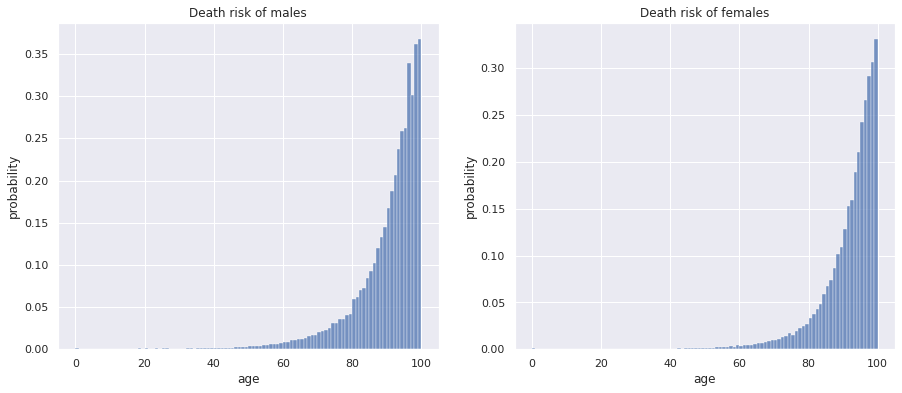

In [11]:
plot_risk_of_death_distributions_by_sex(stats_death_risk_df)

In [12]:
SEX_AGE_INDEX_GAP = 1000

assert SEX_AGE_INDEX_GAP > Cfg.MAX_AGE

# Sex and age to index value
def get_sex_age_index_value(sex, age):
    return sex * SEX_AGE_INDEX_GAP + age

# Inverse for get_sex_age_index_value
def sex_and_age_from_index_value(sex_age_index_value):
    return (int(sex_age_index_value >= SEX_AGE_INDEX_GAP), sex_age_index_value % SEX_AGE_INDEX_GAP)


death_probability_by_sex_and_age_index = {}
death_probability_by_sex_and_age = {0: {}, 1: {}}
for _, row in stats_death_risk_df.iterrows():
    death_probability_by_sex_and_age[row['sex']][row['age']] = row['death_probability']

# TODO this is simple prefill assuming death risk is constant after -> use increasing death risk
for sex in Cfg.SEXES:
    given_max_age = int(max(death_probability_by_sex_and_age[sex].keys()))
    for age in range(given_max_age + 1, Cfg.MAX_AGE + 1):
        death_probability_by_sex_and_age[sex][age] =  death_probability_by_sex_and_age[sex][given_max_age]
    # Let's make sure that there is upper limit for the age
    death_probability_by_sex_and_age[sex][Cfg.MAX_AGE] = 1

for sex in death_probability_by_sex_and_age:
    for age in death_probability_by_sex_and_age[sex]:
        death_probability_by_sex_and_age_index[get_sex_age_index_value(sex, age)] = death_probability_by_sex_and_age[sex][age]

### Fertility

In [13]:
stats_fertility_df = pd.read_csv(os.path.join(Cfg.DATA_DIR, '005_12dm_2020_20220318-232741.csv'), 
                                  encoding='iso-8859-1', skiprows=2, delimiter=";")

def tilastokeskus_transform_fertility_dataframe(df):
    def transform_mother_age(age_str):
        """
        Here we make following simplifications:
        If range given for mother age is like 0-14 then we simplify that all babies for those
        mothers have age 14.
        
        If range given for mother age is like 55- then we simplify that all babies for those
        mothers have age 55.
        
        This concludes that in this case ages 0-13 and 55+ have zero babies
        """
        if age_str.isnumeric():
            return int(age_str)
        if '-' in age_str:
            lowest_age_in_range_str = age_str.split('-')[0].strip()
            biggest_age_in_range_str = age_str.split('-')[-1].strip()
            if biggest_age_in_range_str:
                return transform_mother_age(biggest_age_in_range_str)
            elif lowest_age_in_range_str:
                return transform_mother_age(lowest_age_in_range_str)
        raise ValueError(f"Cannot parse age out of {age_str}")
        
    df['mother_age'] = df['Äidin ikä'].apply(transform_mother_age)
    
    df['total_number_of_children_born'] = df['Miehet Elävänä syntyneet'] + df['Naiset Elävänä syntyneet']
    df = df.drop(df.columns.difference(['mother_age', 'total_number_of_children_born']), 1)
    df = df.dropna()
    return df

stats_fertility_df = tilastokeskus_transform_fertility_dataframe(stats_fertility_df)

stats_fertility_df.head()

,mother_age,total_number_of_children_born
0,14,3
1,15,9
2,16,28
3,17,59
4,18,162


In [14]:
# Babies born in 2020
stats_fertility_df['total_number_of_children_born'].sum()

46463

In [15]:
birth_probability_by_age = {}
for _, row in stats_fertility_df.iterrows():
    population_count = stats_population_df[(stats_population_df['sex'] == 1) & (stats_population_df['age'] == row['mother_age'])]['population_count']
    assert len(population_count) == 1
    population_count = population_count.iloc[0]
    birth_probability = row['total_number_of_children_born'] / population_count
    birth_probability_by_age[row['mother_age']] = birth_probability

for age in range(0, Cfg.MAX_AGE + 1):
    if age not in birth_probability_by_age:
        birth_probability_by_age[age] = 0

### Initialize simulation population

In [16]:
# TODO move this to Cfg for customizability
INITIAL_POPULATION_SIZE = stats_population_df['population_count'].sum()

def create_initial_population(stats_population_df):
    ages = np.zeros(INITIAL_POPULATION_SIZE, dtype=int)
    sexes = np.zeros(INITIAL_POPULATION_SIZE, dtype=int)
    # This is artificial index so that we can utilize vectorized operations for the dataframe (millions of rows are too slow without vectorization)
    sex_age_index = np.zeros(INITIAL_POPULATION_SIZE, dtype=int)

    start_idx = 0
    for _, row in stats_population_df.iterrows():
        end_idx = start_idx + row['population_count']
        ages[start_idx:end_idx] = np.repeat(row['age'], row['population_count'])
        sexes[start_idx:end_idx] = np.repeat(row['sex'], row['population_count'])
        sex_age_index[start_idx:end_idx] = np.repeat(get_sex_age_index_value(row['sex'], row['age']), row['population_count'])
        start_idx = end_idx

    df = pd.DataFrame({'age': ages, 'sex': sexes, 'sex_age_index': sex_age_index})
    dead_df = pd.DataFrame().reindex(columns=df.columns)
    
    return df, dead_df


df, dead_df = create_initial_population(stats_population_df)

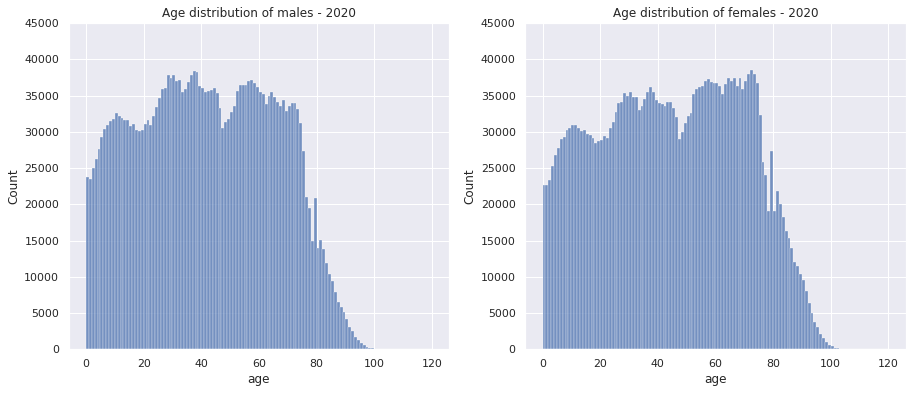

In [17]:
plot_population_age_distributions_by_sex(df, year=2020, aggregated=False)

### Animation utils

In [18]:
def animate_gif(filenames, output_filename, remove_original_images=False):
    output_file = os.path.join(Cfg.IMAGE_DIR, output_filename)
    if os.path.exists(output_filename) and not Cfg.OVERWRITE_IMAGES:
        raise Exception(f"Image {output_filename} already exists!")
    # build gif
    filenames = [os.path.join(Cfg.IMAGE_DIR, filename) for filename in filenames]
    with imageio.get_writer(output_file, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove original images
    if remove_original_images:
        for filename in set(filenames):
            os.remove(filename)

## Simulation

In [19]:
def simulate_one_year(df, dead_df):
    df['random'] = np.random.random(len(df))
    # Get conditional probability of death conditioned on sex
    df['death_probability'] = df['sex_age_index'].map(lambda idx_value: death_probability_by_sex_and_age_index[idx_value])
    dead = df.loc[df['random'] < df['death_probability'], :]
    dead_df = dead_df.append(dead, ignore_index=True)
    df.drop(dead.index, inplace=True)
    # Update ages and related indexes and probabilities
    df['age'] += 1
    df['sex_age_index'] += 1
    
    # TODO there is no need to put this into df
    df['random'] = np.random.random(len(df))
    # Get conditional probability of giving birth conditioned on age
    df['birth_probability'] = df.loc[df['sex'] == 1]['age'].apply(lambda age: birth_probability_by_age[age])
    # Fill zero for males
    df['birth_probability'] = df['birth_probability'].fillna(0)
    newborn_count = len(df[df['random'] < df['birth_probability']])
    
    ages = np.zeros(newborn_count, dtype=int)
    sexes = np.zeros(newborn_count, dtype=int)
    sex_age_index = np.zeros(newborn_count, dtype=int)
    newborn_females_index = round(newborn_count * Cfg.MALE_BIRTH_PROBABILITY)
    sexes[newborn_females_index:] = 1
    sex_age_index[:newborn_females_index] = get_sex_age_index_value(0, 0)
    sex_age_index[newborn_females_index:] = get_sex_age_index_value(1, 0)

    newborn_df = pd.DataFrame({'age': ages, 'sex': sexes, 'sex_age_index': sex_age_index})
    # TODO this resets index - newborn_df index should be adjusted by starting from max+1 of the df index
    df = pd.concat([df, newborn_df], ignore_index=True)
    
    return df, dead_df


def simulate_until(target_year, df, dead_df):
    results = {'population_development': {
        Cfg.INITIAL_YEAR: {
            'total': len(df),
            'males': len(df[df['sex'] == 0]),
            'females': len(df[df['sex'] == 1])
        }
    }}
    for year in range(Cfg.INITIAL_YEAR + 1, target_year + 1):
        # Set fixed seed for the year
        np.random.seed(year)
        df, dead_df = simulate_one_year(df, dead_df)
        results['population_development'][year] = {
            'total': len(df),
            'males': len(df[df['sex'] == 0]),
            'females': len(df[df['sex'] == 1])
        }
        plot_population_age_distributions_by_sex(df, year=year, aggregated=False, save_with_filename=f'age_by_sex_distribution_{year}.png')
    return df, dead_df, results

In [20]:
# We do not show all intermediate graphs so let's not plot them
%matplotlib agg

plot_population_age_distributions_by_sex(stats_population_df, year=2020, save_with_filename="age_by_sex_distribution_2020.png")

assert Cfg.INITIAL_YEAR == 2020
assert Cfg.TARGET_YEAR > Cfg.INITIAL_YEAR

# Create initial population df and df for dead
df, dead_df = create_initial_population(stats_population_df)

# Run simulation
df, dead_df, results = simulate_until(Cfg.TARGET_YEAR, df, dead_df)

# Animate results
animate_gif([f'age_by_sex_distribution_{year}.png' for year in range(Cfg.INITIAL_YEAR, Cfg.TARGET_YEAR + 1)], 'age_by_sex_distribution_animation.gif')

# Put back inline plotting
%matplotlib inline

/mnt/c/Users/OMISTAJA/code/masters-degree/population-simulation/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


### Results of the simulation

![Animated age by sex over simulations](../images/age_by_sex_distribution_animation.gif?q=2)

In [21]:
def plot_population_development(results):
    data = results['population_development']
    # TODO this is global I guess? If so move elsewhere
    sns.set(rc={'figure.figsize':(15, 6)})
    years = list(data.keys())
    totals = [data[year]['total'] for year in data]
    males = [data[year]['males'] for year in data]
    females = [data[year]['females'] for year in data]
    plot_df = pd.DataFrame({'year': years, 'total': totals, 'males': males, 'females': females})
    g = sns.lineplot(data=pd.melt(plot_df, ['year']), x='year', y='value', hue='variable')
    plt.xticks(years, rotation=45)
    plt.ylim(0, 6e6)

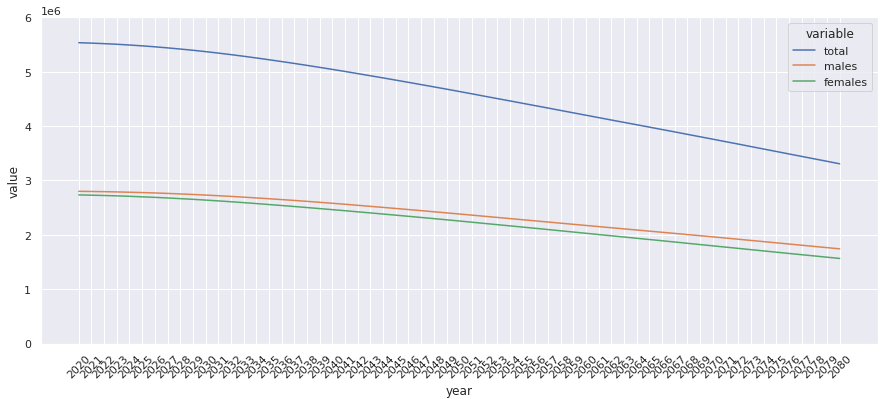

In [22]:
plot_population_development(results)